##**Машинное обучение в задачах визуального распознавания погодных условий для беспилотных автомобилей**


##**План работы:**


Для решения поставленной задачи ,а именно "Машинное обучение в задачах визуального распознавания погодных условий для беспилотных автомобилей", мне нужно выполнить следующие задачи:


**1 - Сбор данных:**

Необходимо найти и собрать хороший набор данных, содержащий изображения различных погодных условий, таких как солнечно, облачно, дождливо, снежно и т. д. Надо убедиться , что данные размечены с соответствующими метками погодных условий.

**2 - Предобработка данных:**

 Разделить набор данных на обучающую, валидационную и тестовую выборки. Нужно нормализовать  изображения, предя значения пикселей к диапазону [0, 1] или [-1, 1]. Возможно, чоо мнепотребуется выполнить аугментацию данных для увеличения размера обучающей выборки и улучшения обобщающей способности модели.

**3 - Создание модели CNN:**

 Необходимо создать  архитектуру CNN с использованием библиотеки Keras. Добавить сверточные слои, слои пулинга и полносвязные слои. В конечном слое использовать  функцию активации softmax для многоклассовой классификации.

**4 - Компиция модели:**

Выберите функцию потерь (SparseCategoricalCrossentropy), оптимизатор ( Adam ) и метрики (accuracy) для компиляции модели.

**5 - Обучение модели:**

нужно непосредственно обучить модель на обучающей выборке, используя валидационную выборку для контоля переобучения. Выберать подходящее количество эпох и размер batch.

**6 - Оценка модели:**

 Дальше нужно оценить производительность модели на тестовой выборке, чтобы определить, наскольок хорошо модель обобщает результаты на новых данных.

**7 - Тонкая настройка и оптимизация:**
 При необходимости мне нужно будет  провести тонкую настройку архитекту модели, параметров обучения или предобработки данных для улучшения производительности модели.


Данный код использует библиотеку **TensorFlow** и ее высокоуровневый **API Keras** для создания, компиляции, обучения и оценки сверточной нейронной сети. Для обработки изображений используется класс **ImageDataGenerator** из **Keras**, который автоматически создает генераторы для чтения и обработки изображений из папок на диске.
Модель определена с использованием нескольких слоев, включая **Conv2D** для свертки, **MaxPooling2D** для субдискретизации, Dense для полносвязного слоя и Dropout для регуляризации. Она состоит из нескольких слоев свертки и субдискретизации, которые последовательно уменьшают размерность входных изображений, и двух полносвязных слоев с функцией активации **ReLU** и слоем Dropout для борьбы с переобучением.
Далее модель компилируется с использованием функции потерь **categorical_crossentropy**, оптимизатора **Adam** и метрики **accuracy**. Затем модель обучается на обучающих данных и оценивается на тестовых данных.
В конце модель сохраняется в файл с расширением h5, который может быть загружен и использован для предсказаний погодных условий на новых изображениях.



In [ ]:
!pip install wget #установка библиотеки для скачивания датасета 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=0be9b8550215bed4f0502892ee5064f4932161297b4efa3f03a534a8c5e9348f
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
import os
import cv2
import shutil
import numpy as np 
import random as rn
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageEnhance
from tensorflow.keras.models import Sequential 
from tensorflow.keras import datasets, layers, models, utils
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU'))) # Тут я добовляю возможность работы непосредственно на процесоре, так как простой оперативной памяти не хватает

Num GPUs Available:  1


In [ ]:
#tf.debugging.set_log_device_placement(True)
#
## Помещаем работу на процессор
#with tf.device('/CPU:0'):
#  a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
#  b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
#
## Запускаем процессор
#c = tf.matmul(a, b)
#print(c)

##**1 - Сбор данных:**


В качестве данных я взял датасет который был представлен в исследовании:

**"Camera as weather sensor: Estimating weather information from single
images"** 2017-ого года.

В данном датасете храниться 183,798 данных.В нем есть 6 классов.

 Но в дальнейшем мне придеться изменить это колличество так как данные разделены не равномерно.

In [ ]:
import wget # скачиваем датасет
url = 'https://www.cs.ccu.edu.tw/~wtchu/projects/Weather/Image.zip'
filename = wget.download(url)

In [ ]:
!unzip Image.zip # разархивируем его

##**2 - Предобработка данных:**

In [ ]:
sunnylimit = 4000  # Обрезаем датасет для адекватного распределения данных по классам
cloudylimit = 4000
zotherlimit = 600

def removefiles(folderpath, limit):
    files = os.listdir(folderpath)
    if len(files) > limit:

        files.sort(key=lambda x: os.path.getctime(os.path.join(folderpath, x)))
        for i in range(len(files) - limit):
            os.remove(os.path.join(folderpath, files[i]))

In [ ]:
sunnyfolder = "/content/Image/sunny" # убираем лишние данные
removefiles(sunnyfolder, sunnylimit)
cloudyfolder = "/content/Image/cloudy"
removefiles(cloudyfolder, cloudylimit)
zotherfolder = "/content/Image/z-other"
removefiles(zotherfolder, zotherlimit)

In [ ]:
names = ["cloudy","foggy","rain","snow","sunny","z-other" ]


In [ ]:
c = 0 #переменная для теста

for i in names: # Тут мы дополняем датасет что бы было ровное распределение данных по классам . Я использую увеличение контрастности , поворот изображений и изменение яркости
  for dirpath, _, filenames in os.walk(f'/content/Image/{i}'):
    for filename in filenames:
      if i == "cloudy" or  i == "sunny" or i  == "z-other":
        break
      c+=1
      factor = rn.uniform(0.5,2)

      sample = Image.open(f'/content/Image/{i}/{filename}') # поворот изображений
      vertical_img = sample.transpose(method=Image.FLIP_LEFT_RIGHT)

      enhancer = ImageEnhance.Contrast(sample) # увеличение контрастности 
      im_cont = enhancer.enhance(factor)

      filter = ImageEnhance.Color(sample) # изменение яркости
      im_sat = filter.enhance(factor)

      new_flip = f'image_flip{c}.jpg'
      new_cont = f'image_cont{c}.jpg'
      new_sat = f'image_sat{c}.jpg'
      vertical_img.save(f'/content/Image/{i}/{new_flip}')
      im_cont.save(f'/content/Image/{i}/{new_cont}')
      im_sat.save(f'/content/Image/{i}/{new_sat}')


In [ ]:
shutil.rmtree('/content/Image/z-other')
shutil.rmtree('/content/Image/foggy') #удаляю ненужные папки 

На данном этапе у меня получился датасет из 4 классов содержащих суммарно 20185 изображений которые равномернно распределены.

##**3 - Создание модели CNN:**

Существует несколько методов для классификации изображений на Python. Вот некоторые из них:

##**Сверточные нейрные сети (CNN)**:
 CNN являются наиболее популярным и эффективным методом для классификации изображений. Они используют сверточные слои для автоматического извлечения признаков из изображений. Библиотеки, такие как TensorFlow и Keras, предоставляют инструменты для создания и обучения CNN.

##**Перенос обучения**:
Перенос обучения - это метод, при котор предварительно обученная модель (например, VGG, ResNet, Inception) используется как основа для классификации изображений. Модель может быть дообучена на новом наборе данных с помощью библиотек, таких как TensorFlow и Keras.

##**Метод опорных векторов (SVM)**:
 SVM - это классический алгоритм машинного обучения, который может быть применен для классификации изображений. Изображения должны быть предварительно обработаны и преобразованы в вектор признаков перед использованием SVM. Библиотека scikit-learn предоставляет инструменты для работы с SVM.

##**Деревья решений и случайные леса**:
Деревья решений и случайные леса также могут быть использованы для классификации изображений после извлечения признаков из изображений. Scikit-learn предоставляет инструменты для работы с этими алгоритмами.

##**k-ближайших соседей (k-NN)**:
 k-NN - это алгоритм машинного обения, который может быть использован для классификации изображений на основе близости признаков. Изображения должны быть предварительно обработаны и преобразованы в векторы признаков использованием k-NN. Scikit-learn предоставляет инструменты для работы с k-NN.

##**Наивный байесовский классификатор**:
 Этот агоритм основан на применении теоремы Байеса с "наивным" предположением о независимости признаков. Изображения должны быть предварительно обработаны и преобразованы в векторы признаков перед использованием наивного байесовского классификатора. Scikit-learn предоставляет инструменты для работы с этим алгоритмом.


Важно отметить, что для большинства методов, основанных на классическом машинном обучении (SVM, деревья решений, k-NN, наивный байесовский классификатор), потебуется предварительная обработка изображений и извлечение признаков с использованием методов, таких как SIFT, SURF, HOG или других. В то время как сверточные нейронные сети и перенос обучения автоматически извлекают признаки из изображений в процессе обучения.Именно поэтому я выбрал Сверточные нейрные сети (CNN).Но несмотря на то что CNN не требует предобработки данных я все равно их сделал так как они были не очень хорошие.


**Для состовления моледи я буду использовать сверточную нейронную сеть где парамерты для ввода расчитываются по слеедующим формулам**


***Размер выходного тензора (изображения) слоя свертки.***

O = Размер (ширина) выходного изображения.\
I = Размер (ширина) входного изображения.\
K = Размер (ширина) ядер, используемых в слое свертки.\
N = Количество ядер.\
S = Шаг операции свертки.\
P = Заполнение (padding).

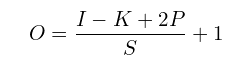
(добавлено 1 из-за условия смещения для каждого фильтра)

**Размер выходного тензора (изображения) слоя MaxPool**
$O$ = Размер (ширина) выходного изображения.

$I$ = Размер (ширина) входного изображения.

$S$ = Шаг операции свертки.

$P_s$ = Размер пула (pool size).

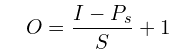

**В сверточной нейронной сети каждый слой имеет два типа параметров: веса и смещения. Общее количество параметров - это сумма всех весов и смещений.**

$W_c$ = Количество весов слоя свертки.

$B_c$ = Количество смещений слоя свертки.

$P_c$ = Количество параметров слоя свертки.

$K$ = Размер (ширина) ядер, используемых в слое свертки.

$N$ = Количество ядер.

$C$ = Количество каналов входного изображения.

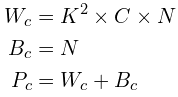

**FC-1: Количество параметров полносвязного (FC) слоя, подключенного к слою свертки**
$W_{cf}$ = Количество весов полносвязного слоя, подключенного к слою свертки.

$B_{cf}$ = Количество смещений полносвязного слоя, подключенного к слою свертки.

$O$ = Размер (ширина) выходного изображения предыдущего слоя свертки.

$N$ = Количество ядер в предыдущем слое свертки.

$F$ = Количество нейронов в полносвязном слое.

![image.png](|)

**FC-2: Количество параметров полносвязного (FC) слоя, подключенного к другому полносвязному слою**

$W_{ff}$ = Количество весов полносвязного слоя, подключенного к другому полносвязному слою.

$B_{ff}$ = Количество смещений полносвязного слоя, подключенного к другому полносвязному слою.

$P_{ff}$ = Количество параметров полносвязного слоя, подключенного к другому полносвязному слою.

$F$ = Количество нейронов в полносвязном слое.

$F_{-1}$ = Количество нейронов в предыдущем полносвязном слое.

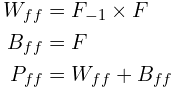

в приведенном выше уравнении $F_{-1}$*$F$ - это общее количество весов соединений от нейронов предыдущего FC-слоя к нейронам текущего FC-слоя. Общее количество смещений совпадает с количеством нейронов (F).

По расчетам должно было получиться следущее

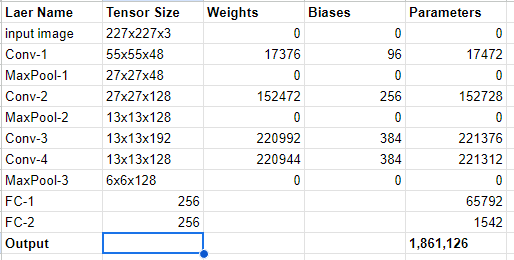

In [ ]:
#Создаем модель. За основу я взял модель AlexNet

In [ ]:
madel = Sequential()
#задаем размер исходного изображения 
# Добавляем слой свертки
madel.add(Conv2D(48, input_shape=(227, 227, 3), kernel_size=(11, 11), strides=(4, 4), activation="relu"))
# Добавляем слой пулинга
madel.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
madel.add(Conv2D(128, kernel_size=(5, 5), strides=(1, 1), padding="same", activation="relu"))
madel.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
madel.add(Conv2D(192, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu"))

madel.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu"))
madel.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
# переход от сверточных слоев к полносвязным
madel.add(layers.Flatten())
# Полносвязный слой
madel.add(layers.Dense(256, activation="relu"))
# Dropout для регуляризации
madel.add(layers.Dropout(0.5))
madel.add(layers.Dense(256, activation="relu"))
madel.add(layers.Dropout(0.5))

# Добавляем выходной слой с функцией активации softmax
madel.add(layers.Dense(6, activation="softmax"))

In [ ]:
madel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 48)        17472     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 48)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 128)       153728    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 192)       221376    
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 128)       2

In [ ]:
#Как мы видим значения совпали


In [ ]:
madel.compile(optimizer='adam', #Компилируем нашу модель 
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [ ]:
batch_size = 300
img_height = 227
img_width = 227

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory( #тут мы создаем тренировочную выборку
  "/content/Image/",
  validation_split=0.1,
  subset="training",
  seed=228,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 18484 files belonging to 4 classes.
Using 16636 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory( #тут мы создаем тестовую  выборку
  "/content/Image/",
  validation_split=0.1,
  subset="validation",
  seed=228,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 18484 files belonging to 4 classes.
Using 1848 files for validation.


In [ ]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(  #тут мы создаем проверочную выборку
        "/content/Image/", 
        target_size=(227, 227),
        batch_size=1,
        class_mode='categorical',
        shuffle=True)

Found 18484 images belonging to 4 classes.


In [ ]:
dir(train_ds)

In [ ]:
class_names = train_ds.class_names # проверяем правильно расставились классы на датасет
print(class_names)

['cloudy', 'rain', 'snow', 'sunny']


In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255) # ту мы нормализуем слои
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

In [ ]:
history = madel.fit(train_ds,  #обучаем нейронную сеть
          validation_data=val_ds,
          epochs=20)

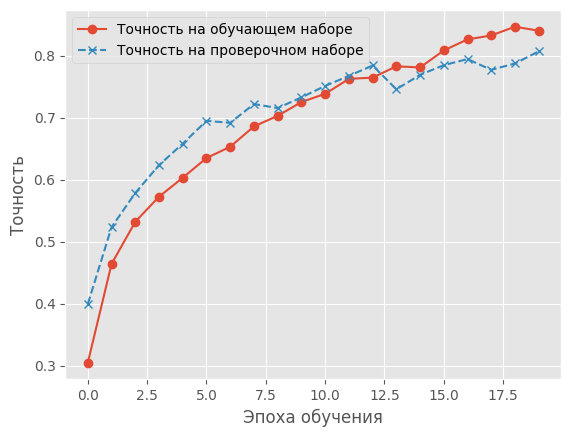

In [ ]:
plt.style.use('ggplot')  # Используем стиль "ggplot" для графика
#Визуализируем работу модели
plt.plot(history.history['accuracy'], marker='o', linestyle='-', label='Точность на обучающем наборе')
plt.plot(history.history['val_accuracy'], marker='x', linestyle='--', label='Точность на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Точность')
plt.legend()
plt.show()

In [ ]:
test_loss, test_acc = madel.evaluate(val_ds) 
print('Test accuracy:', test_acc)

7/7 [==============================] - 3s 124ms/step - loss: 0.5463 - accuracy: 0.8068
Test accuracy: 0.8068181872367859


In [ ]:
pred = madel.predict(test_generator)

18484/18484 [==============================] - 107s 6ms/step


In [ ]:
class_ = np.argmax(pred[1])
print(class_names[class_])

rain


In [ ]:

train_ds

In [ ]:
pred[1]

In [ ]:
tf.keras.utils.plot_model(madel,  show_shapes=True)

In [ ]:
madel.save("/content/weather_conditions_model.h5")# сохраняем нашу модель 

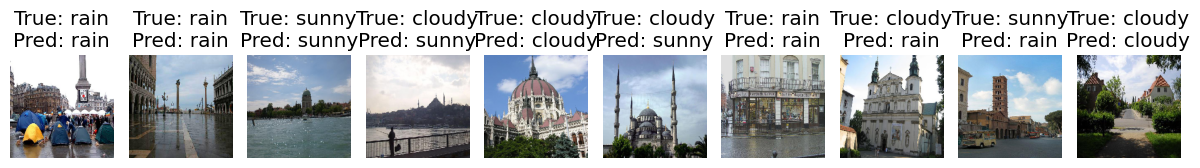

In [ ]:
class_labels = list(test_generator.class_indices.keys())

# выбор 10 случайных изображений из тестовых данных
indices = np.random.choice(1000, size=10, replace=True)

# вывод изображений и подписей к ним
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    if i < 10:
        # загрузка изображения
        img, label = test_generator[indices[i]]
        img = img.squeeze()
        
        # получение метки класса
        true_label = class_labels[np.argmax(label)]
        
        # получение предсказания модели
        pred_label = class_labels[np.argmax(pred[indices[i]])]
        
        # вывод изображения
        ax.imshow(img)
        ax.set_title(f'True: {true_label}\nPred: {pred_label}')
        ax.axis('off')
plt.tight_layout()
plt.show()

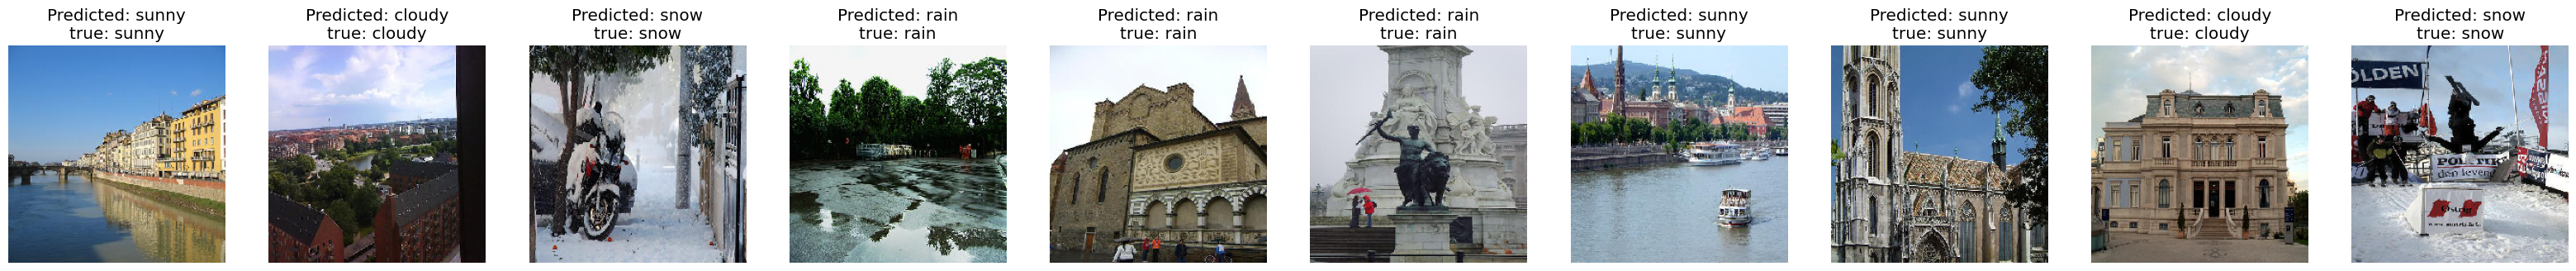

In [ ]:
import random as rd
class_labels = list(test_generator.class_indices.keys())
fig, axs = plt.subplots(1, 10, figsize=(40, 20))
axs = axs.flatten()

for i in range(10):
  a = rd.randint(1, 1000)
  img, label = test_generator[a]
  true_label = class_labels[np.argmax(label)]
  img = img[0]
  img = img * 255

  axs[i].imshow(img.astype(np.uint8))
  predicted_label = np.argmax(label)
  axs[i].set_title(f"Predicted: {class_names[predicted_label]}\ntrue: {true_label}")
  axs[i].axis('off')